In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import pandas as pd
from torch.utils.data import Dataset
import os
import torchaudio

class My_Dataset(Dataset):

    def __init__(self, csv_file, root_dir, set_number):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audio files.
            set_number (int): Set number to filter the samples.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        filtered_indices = []
        for idx in range(len(self.data)):
            set_value = int(self.data.iloc[idx, 1])
            if set_value == self.set_number:
                filtered_indices.append(idx)
        return filtered_indices

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2])
        waveform, _ = torchaudio.load(file)
        return waveform, class_label

csv_file = 'dataset_2.csv'
root_dir = 'dataset'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)
print(train_dataset[0])
print(test_dataset[0])
print(valid_dataset[0])


cpu
(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0458,  0.0068,  0.0377]]), 1)
(tensor([[-0.0005, -0.0052,  0.0002,  ...,  0.0111,  0.0040,  0.0000]]), 4)
(tensor([[0.0018, 0.0032, 0.0043,  ..., 0.0025, 0.0015, 0.0013]]), 2)


In [2]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128

classes = ['down', 'left', 'right', 'stop', 'up']

torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedWaveNet(nn.Module):
    def __init__(self, num_classes, num_channels=1, num_layers=4, num_filters=8, dilation_rates=None):
        super(SimplifiedWaveNet, self).__init__()
        self.num_layers = num_layers
        
        self.init_conv = nn.Conv1d(num_channels, num_filters, kernel_size=1)

        self.conv1 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=3, padding=1, dilation=2)
        self.conv2 = nn.Conv1d(num_filters * 2, num_filters * 4, kernel_size=3, padding=2, dilation=4)
        self.conv3 = nn.Conv1d(num_filters * 4, num_filters * 8, kernel_size=3, padding=4, dilation=8)
        self.conv4 = nn.Conv1d(num_filters * 8, num_filters * 16, kernel_size=3, padding=8, dilation=16)

        self.pool = nn.MaxPool1d(4)

        self.final_conv = nn.Conv1d(256, 128, kernel_size=1)
        self.linear = nn.Linear(128 * 57 * 1, 256)
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x4 = self.pool(F.relu(self.conv4(x3)))
        x5 = self.final_conv(x4)
        # print(x4.shape)
        x5 = x5.view(x5.size(0), -1)
        x6 = F.relu(self.linear(x5))
        x7 = self.linear2(x6)
        return x7



def get_simplified_wavenet(num_classes, num_channels=1, num_layers=3, num_filters=16, dilation_rates=None, device='cpu'):
    model = SimplifiedWaveNet(num_classes, num_channels, num_layers, num_filters, dilation_rates)
    return model.to(device)

model=get_simplified_wavenet(5)


import torch.optim as optim 

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
criterion = nn.CrossEntropyLoss()


In [6]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [11]:
n_epoch = 10
log_interval = 20

import torch.optim as optim
from tqdm import tqdm

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'vgg_gsc.pt')
        pbar.update(1)


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/13363 (0%)]	Loss: 0.250087
Train Epoch: 1 [1280/13363 (10%)]	Loss: 0.152187
Train Epoch: 1 [2560/13363 (19%)]	Loss: 0.334436
Train Epoch: 1 [3840/13363 (29%)]	Loss: 0.294614
Train Epoch: 1 [5120/13363 (38%)]	Loss: 0.391946
Train Epoch: 1 [6400/13363 (48%)]	Loss: 0.324989
Train Epoch: 1 [7680/13363 (57%)]	Loss: 0.193525
Train Epoch: 1 [8960/13363 (67%)]	Loss: 0.222321
Train Epoch: 1 [10240/13363 (77%)]	Loss: 0.178777
Train Epoch: 1 [11520/13363 (86%)]	Loss: 0.434090
Train Epoch: 1 [12800/13363 (96%)]	Loss: 0.361163


 10%|█         | 1/10 [02:42<24:22, 162.46s/it]


Test set: Average loss: 0.3820, Accuracy: 3296/3818 (86%)

Train Epoch: 2 [0/13363 (0%)]	Loss: 0.139321
Train Epoch: 2 [1280/13363 (10%)]	Loss: 0.262853
Train Epoch: 2 [2560/13363 (19%)]	Loss: 0.452480
Train Epoch: 2 [3840/13363 (29%)]	Loss: 0.318135
Train Epoch: 2 [5120/13363 (38%)]	Loss: 0.347080
Train Epoch: 2 [6400/13363 (48%)]	Loss: 0.246928
Train Epoch: 2 [7680/13363 (57%)]	Loss: 0.223522
Train Epoch: 2 [8960/13363 (67%)]	Loss: 0.095664
Train Epoch: 2 [10240/13363 (77%)]	Loss: 0.149891
Train Epoch: 2 [11520/13363 (86%)]	Loss: 0.293727
Train Epoch: 2 [12800/13363 (96%)]	Loss: 0.175024


 20%|██        | 2/10 [05:28<21:57, 164.72s/it]


Test set: Average loss: 0.3747, Accuracy: 3308/3818 (87%)

Train Epoch: 3 [0/13363 (0%)]	Loss: 0.463097
Train Epoch: 3 [1280/13363 (10%)]	Loss: 0.374649
Train Epoch: 3 [2560/13363 (19%)]	Loss: 0.172160
Train Epoch: 3 [3840/13363 (29%)]	Loss: 0.098572
Train Epoch: 3 [5120/13363 (38%)]	Loss: 0.455465
Train Epoch: 3 [6400/13363 (48%)]	Loss: 0.186845
Train Epoch: 3 [7680/13363 (57%)]	Loss: 0.191107
Train Epoch: 3 [8960/13363 (67%)]	Loss: 0.418233
Train Epoch: 3 [10240/13363 (77%)]	Loss: 0.305396
Train Epoch: 3 [11520/13363 (86%)]	Loss: 0.378568
Train Epoch: 3 [12800/13363 (96%)]	Loss: 0.193174


 30%|███       | 3/10 [07:50<18:00, 154.42s/it]


Test set: Average loss: 0.3534, Accuracy: 3345/3818 (88%)

Train Epoch: 4 [0/13363 (0%)]	Loss: 0.170642
Train Epoch: 4 [1280/13363 (10%)]	Loss: 0.212223
Train Epoch: 4 [2560/13363 (19%)]	Loss: 0.217012
Train Epoch: 4 [3840/13363 (29%)]	Loss: 0.348144
Train Epoch: 4 [5120/13363 (38%)]	Loss: 0.295581
Train Epoch: 4 [6400/13363 (48%)]	Loss: 0.219701
Train Epoch: 4 [7680/13363 (57%)]	Loss: 0.095555
Train Epoch: 4 [8960/13363 (67%)]	Loss: 0.206161
Train Epoch: 4 [10240/13363 (77%)]	Loss: 0.219153
Train Epoch: 4 [11520/13363 (86%)]	Loss: 0.231829
Train Epoch: 4 [12800/13363 (96%)]	Loss: 0.314036


 40%|████      | 4/10 [10:16<15:06, 151.02s/it]


Test set: Average loss: 0.3411, Accuracy: 3360/3818 (88%)

Train Epoch: 5 [0/13363 (0%)]	Loss: 0.174551
Train Epoch: 5 [1280/13363 (10%)]	Loss: 0.190760
Train Epoch: 5 [2560/13363 (19%)]	Loss: 0.257675
Train Epoch: 5 [3840/13363 (29%)]	Loss: 0.228831
Train Epoch: 5 [5120/13363 (38%)]	Loss: 0.197727
Train Epoch: 5 [6400/13363 (48%)]	Loss: 0.461462
Train Epoch: 5 [7680/13363 (57%)]	Loss: 0.125373
Train Epoch: 5 [8960/13363 (67%)]	Loss: 0.250510
Train Epoch: 5 [10240/13363 (77%)]	Loss: 0.236157
Train Epoch: 5 [11520/13363 (86%)]	Loss: 0.269428
Train Epoch: 5 [12800/13363 (96%)]	Loss: 0.091019


 50%|█████     | 5/10 [12:53<12:44, 152.95s/it]


Test set: Average loss: 0.3326, Accuracy: 3376/3818 (88%)

Train Epoch: 6 [0/13363 (0%)]	Loss: 0.319216
Train Epoch: 6 [1280/13363 (10%)]	Loss: 0.225750
Train Epoch: 6 [2560/13363 (19%)]	Loss: 0.282435
Train Epoch: 6 [3840/13363 (29%)]	Loss: 0.169338
Train Epoch: 6 [5120/13363 (38%)]	Loss: 0.168172
Train Epoch: 6 [6400/13363 (48%)]	Loss: 0.169518
Train Epoch: 6 [7680/13363 (57%)]	Loss: 0.280445
Train Epoch: 6 [8960/13363 (67%)]	Loss: 0.146587
Train Epoch: 6 [10240/13363 (77%)]	Loss: 0.248507
Train Epoch: 6 [11520/13363 (86%)]	Loss: 0.206465
Train Epoch: 6 [12800/13363 (96%)]	Loss: 0.174343


 60%|██████    | 6/10 [16:03<11:03, 165.79s/it]


Test set: Average loss: 0.3484, Accuracy: 3353/3818 (88%)

Train Epoch: 7 [0/13363 (0%)]	Loss: 0.142101
Train Epoch: 7 [1280/13363 (10%)]	Loss: 0.211613
Train Epoch: 7 [2560/13363 (19%)]	Loss: 0.264292
Train Epoch: 7 [3840/13363 (29%)]	Loss: 0.184442
Train Epoch: 7 [5120/13363 (38%)]	Loss: 0.203195
Train Epoch: 7 [6400/13363 (48%)]	Loss: 0.095269
Train Epoch: 7 [7680/13363 (57%)]	Loss: 0.104905
Train Epoch: 7 [8960/13363 (67%)]	Loss: 0.250888
Train Epoch: 7 [10240/13363 (77%)]	Loss: 0.145400
Train Epoch: 7 [11520/13363 (86%)]	Loss: 0.182825
Train Epoch: 7 [12800/13363 (96%)]	Loss: 0.241391


 70%|███████   | 7/10 [18:53<08:20, 166.96s/it]


Test set: Average loss: 0.3226, Accuracy: 3396/3818 (89%)

Train Epoch: 8 [0/13363 (0%)]	Loss: 0.216786
Train Epoch: 8 [1280/13363 (10%)]	Loss: 0.145195
Train Epoch: 8 [2560/13363 (19%)]	Loss: 0.067711
Train Epoch: 8 [3840/13363 (29%)]	Loss: 0.168424
Train Epoch: 8 [5120/13363 (38%)]	Loss: 0.084001
Train Epoch: 8 [6400/13363 (48%)]	Loss: 0.190858
Train Epoch: 8 [7680/13363 (57%)]	Loss: 0.166975
Train Epoch: 8 [8960/13363 (67%)]	Loss: 0.216834
Train Epoch: 8 [10240/13363 (77%)]	Loss: 0.314340
Train Epoch: 8 [11520/13363 (86%)]	Loss: 0.181929
Train Epoch: 8 [12800/13363 (96%)]	Loss: 0.230772


 80%|████████  | 8/10 [21:53<05:42, 171.24s/it]


Test set: Average loss: 0.3493, Accuracy: 3360/3818 (88%)

Train Epoch: 9 [0/13363 (0%)]	Loss: 0.169857
Train Epoch: 9 [1280/13363 (10%)]	Loss: 0.174552
Train Epoch: 9 [2560/13363 (19%)]	Loss: 0.132311
Train Epoch: 9 [3840/13363 (29%)]	Loss: 0.197300
Train Epoch: 9 [5120/13363 (38%)]	Loss: 0.102281
Train Epoch: 9 [6400/13363 (48%)]	Loss: 0.389540
Train Epoch: 9 [7680/13363 (57%)]	Loss: 0.134782
Train Epoch: 9 [8960/13363 (67%)]	Loss: 0.164998
Train Epoch: 9 [10240/13363 (77%)]	Loss: 0.158581
Train Epoch: 9 [11520/13363 (86%)]	Loss: 0.143611
Train Epoch: 9 [12800/13363 (96%)]	Loss: 0.137646


 90%|█████████ | 9/10 [24:31<02:46, 166.98s/it]


Test set: Average loss: 0.3228, Accuracy: 3410/3818 (89%)

Train Epoch: 10 [0/13363 (0%)]	Loss: 0.135524
Train Epoch: 10 [1280/13363 (10%)]	Loss: 0.137099
Train Epoch: 10 [2560/13363 (19%)]	Loss: 0.166121
Train Epoch: 10 [3840/13363 (29%)]	Loss: 0.179528
Train Epoch: 10 [5120/13363 (38%)]	Loss: 0.190773
Train Epoch: 10 [6400/13363 (48%)]	Loss: 0.185185
Train Epoch: 10 [7680/13363 (57%)]	Loss: 0.170870
Train Epoch: 10 [8960/13363 (67%)]	Loss: 0.136466
Train Epoch: 10 [10240/13363 (77%)]	Loss: 0.204862
Train Epoch: 10 [11520/13363 (86%)]	Loss: 0.165322
Train Epoch: 10 [12800/13363 (96%)]	Loss: 0.265541


100%|██████████| 10/10 [27:19<00:00, 163.92s/it]


Test set: Average loss: 0.3296, Accuracy: 3386/3818 (89%)



              precision    recall  f1-score   support

        stop       0.89      0.91      0.90      7770
          up       0.86      0.87      0.86      7160
        down       0.86      0.81      0.83      7820
        left       0.91      0.92      0.92      7910
       right       0.88      0.89      0.88      7520

    accuracy                           0.88     38180
   macro avg       0.88      0.88      0.88     38180
weighted avg       0.88      0.88      0.88     38180

[[7054   74  406  150   86]
 [ 128 6199  447  136  250]
 [ 473  637 6358   95  257]
 [ 157   89   47 7249  368]
 [ 133  184  171  302 6730]]


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1a1cb750210>,
 None)

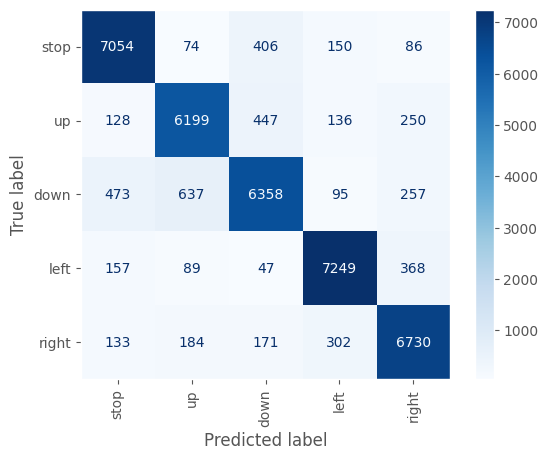

In [12]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=['stop', 'up', 'down', 'left', 'right'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['stop', 'up', 'down', 'left', 'right'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=None), plt.grid(False)
